In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  # allows samplers inside
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score


In [6]:
#load dataset
df = pd.read_csv("diabetes_dataset.csv")
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(":", "_")
      .str.replace("-", "_")
      .str.replace(" ", "_")
)

#drop location
df = df.drop(columns=['location'])

# reencode gender and smoking history
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0, 'Other' : 2})
df['smoking_history'] = df['smoking_history'].str.lower().str.replace(" ", "_")
df = pd.get_dummies(df, columns=['smoking_history'], drop_first=True)

# check
print("Columns:", df.columns.tolist())

Columns: ['year', 'gender', 'age', 'race_africanamerican', 'race_asian', 'race_caucasian', 'race_hispanic', 'race_other', 'hypertension', 'heart_disease', 'bmi', 'hba1c_level', 'blood_glucose_level', 'diabetes', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_no_info', 'smoking_history_not_current']


In [7]:
# Define target
y = df['diabetes']                # target variable
X = df.drop(columns=['diabetes'])

In [8]:
#base preprocessing
base_preprocess = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
]


In [9]:
# C. Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train class counts:", Counter(y_train))
print("Test  class counts:", Counter(y_test))

print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in X_test:", np.isnan(X_test).sum())

Train class counts: Counter({0: 73200, 1: 6800})
Test  class counts: Counter({0: 18300, 1: 1700})
NaNs in X_train: year                           0
gender                         0
age                            0
race_africanamerican           0
race_asian                     0
race_caucasian                 0
race_hispanic                  0
race_other                     0
hypertension                   0
heart_disease                  0
bmi                            0
hba1c_level                    0
blood_glucose_level            0
smoking_history_ever           0
smoking_history_former         0
smoking_history_never          0
smoking_history_no_info        0
smoking_history_not_current    0
dtype: int64
NaNs in X_test: year                           0
gender                         0
age                            0
race_africanamerican           0
race_asian                     0
race_caucasian                 0
race_hispanic                  0
race_other                     

In [10]:
#Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [11]:
# Define samplers
samplers = {
    "Original": None,  # no resampling
    "Undersample": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42)
}
#Models, KNN and logistic regression
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=2000, random_state=42)  # lbfgs default, OK
}
results=[]

In [ ]:
for s_name, sampler in samplers.items():
    for m_name, model in models.items():

        if sampler is None:
            pipe = ImbPipeline(steps=[
                ("scaler", StandardScaler()),
                ("model", model)
            ])
        else:
            pipe = ImbPipeline(steps=[
                ("scaler", StandardScaler()),
                ("sampler", sampler),
                ("model", model)
            ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results.append({
            "Resampling": s_name,
            "Model": m_name,
            "Accuracy": rep["accuracy"],
            "Precision_pos": rep["1"]["precision"],
            "Recall_pos": rep["1"]["recall"],
            "F1_pos": rep["1"]["f1-score"]
        })

df_results = pd.DataFrame(results)
print(df_results)

In [ ]:
results_original = []

for model_name, model in {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=2000, random_state=42)
}.items():

    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results_original.append({
        "Model": model_name,
        "Precision_pos": rep["1"]["precision"],
        "Recall_pos": rep["1"]["recall"],
        "F1_pos": rep["1"]["f1-score"],
        "Balanced_Acc": bal_acc
    })

df_original = pd.DataFrame(results_original)
print("=== Original Data Results ===")
print(df_original)

=== Original Data Results ===
    Model  Precision_pos  Recall_pos    F1_pos  Balanced_Acc
0     KNN       0.884250    0.548235  0.676834      0.770784
1  LogReg       0.866079    0.635294  0.732949      0.813084


In [ ]:
# UNDERSAMPLING

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

results_under = []

for model_name, model in {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=2000, random_state=42)
}.items():

    pipe = ImbPipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("undersample", RandomUnderSampler(random_state=42)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results_under.append({
        "Model": model_name,
        "Precision_pos": rep["1"]["precision"],
        "Recall_pos": rep["1"]["recall"],
        "F1_pos": rep["1"]["f1-score"],
        "Balanced_Acc": bal_acc
    })

df_under = pd.DataFrame(results_under)
print("=== Undersampling Results ===")
print(df_under)

=== Undersampling Results ===
    Model  Precision_pos  Recall_pos    F1_pos  Balanced_Acc
0     KNN        0.34072    0.868235  0.489390      0.856085
1  LogReg        0.41843    0.884118  0.568027      0.884982


In [ ]:
# SMOTE OVERSAMPLING

##viSUALIZE HOW THE DATASET CHANGES WITH SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_res))

from imblearn.over_sampling import SMOTE

results_smote = []

for model_name, model in {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=2000, random_state=42)
}.items():

    pipe = ImbPipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results_smote.append({
        "Model": model_name,
        "Precision_pos": rep["1"]["precision"],
        "Recall_pos": rep["1"]["recall"],
        "F1_pos": rep["1"]["f1-score"],
        "Balanced_Acc": bal_acc
    })

df_smote = pd.DataFrame(results_smote)
print("=== SMOTE Results ===")
print(df_smote)

After SMOTE: Counter({1: 73200, 0: 73200})
=== SMOTE Results ===
    Model  Precision_pos  Recall_pos    F1_pos  Balanced_Acc
0     KNN       0.452341    0.790000  0.575284      0.850574
1  LogReg       0.424936    0.874118  0.571868      0.882113


In [ ]:
final_results = pd.concat([
    df_original.assign(Resampling="Original"),
    df_under.assign(Resampling="Undersample"),
    df_smote.assign(Resampling="SMOTE")
], ignore_index=True)

print("\n=== Combined Results Summary ===")
print(final_results)


=== Combined Results Summary ===
    Model  Precision_pos  Recall_pos    F1_pos  Balanced_Acc   Resampling
0     KNN       0.884250    0.548235  0.676834      0.770784     Original
1  LogReg       0.866079    0.635294  0.732949      0.813084     Original
2     KNN       0.340720    0.868235  0.489390      0.856085  Undersample
3  LogReg       0.418430    0.884118  0.568027      0.884982  Undersample
4     KNN       0.452341    0.790000  0.575284      0.850574        SMOTE
5  LogReg       0.424936    0.874118  0.571868      0.882113        SMOTE


In [ ]:
##Visualize what changed
from collections import Counter
print("Before resampling:", Counter(y_train))
X_res, y_res = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print("After undersampling:", Counter(y_res))


Before resampling: Counter({0: 73200, 1: 6800})
After undersampling: Counter({0: 6800, 1: 6800})


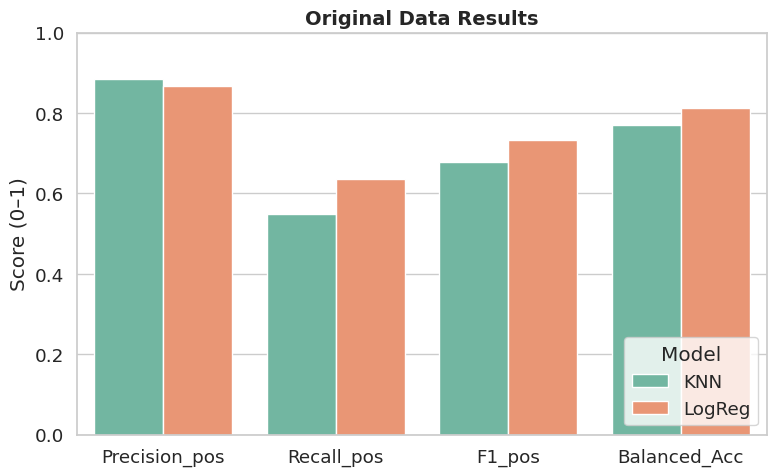

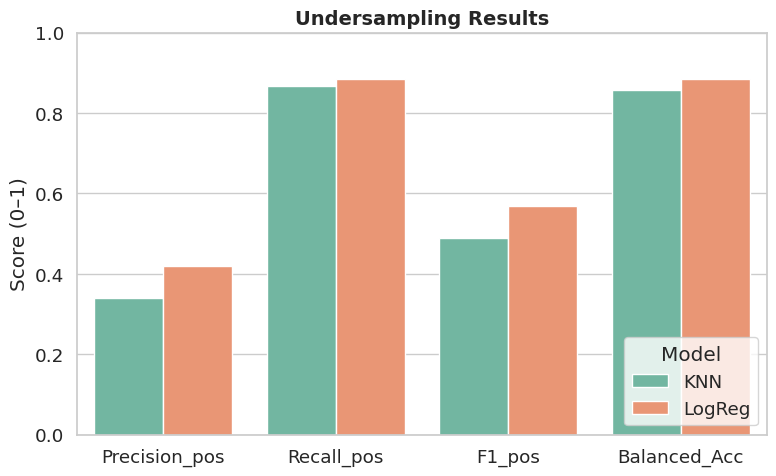

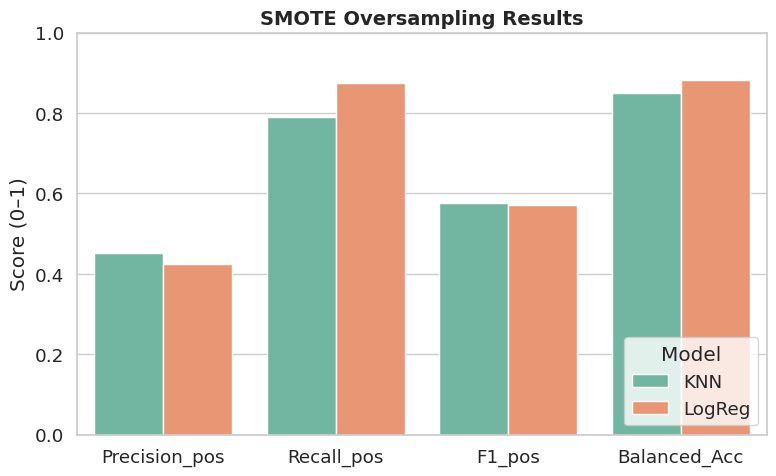

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for better plot style
sns.set(style="whitegrid", font_scale=1.2)

def plot_results(df, title):
    """
    Create a bar chart for each resampling method.
    df: dataframe with columns ["Model", "Precision_pos", "Recall_pos", "F1_pos", "Balanced_Acc"]
    """
    # Melt dataframe for plotting (long format)
    df_long = df.melt(id_vars="Model",
                      value_vars=["Precision_pos", "Recall_pos", "F1_pos", "Balanced_Acc"],
                      var_name="Metric", value_name="Score")

    plt.figure(figsize=(8,5))
    sns.barplot(data=df_long, x="Metric", y="Score", hue="Model", palette="Set2")

    plt.title(title, fontsize=14, weight="bold")
    plt.ylabel("Score (0–1)")
    plt.ylim(0, 1)
    plt.xlabel("")
    plt.legend(title="Model", loc="lower right")
    plt.tight_layout()
    plt.show()


# Plot results for each scenario
plot_results(df_original, "Original Data Results")
plot_results(df_under, "Undersampling Results")
plot_results(df_smote, "SMOTE Oversampling Results")
